# Data and Lib Initialization

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [80]:
# Hyperparameters
batch_size = 1
learning_rate = 1e-4
epochs = 10

In [15]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


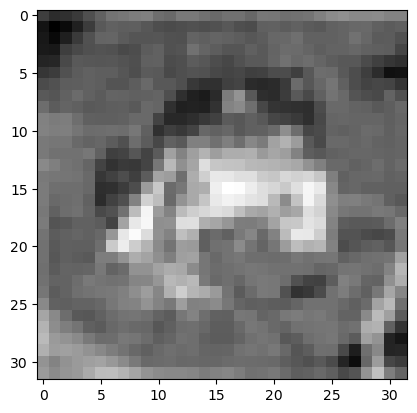

In [19]:
data = train_dataset[0][0]
import matplotlib.pyplot as plt
# img = data.permute(1, 2, 0).numpy()
img = data[0]
plt.imshow(img, cmap="gray")

In [21]:
img

tensor([[0.2392, 0.1765, 0.1882,  ..., 0.5373, 0.5098, 0.5059],
        [0.0745, 0.0000, 0.0392,  ..., 0.3725, 0.3529, 0.3686],
        [0.0941, 0.0353, 0.1216,  ..., 0.3529, 0.3569, 0.3137],
        ...,
        [0.6784, 0.6039, 0.6157,  ..., 0.5255, 0.1412, 0.1490],
        [0.5725, 0.5059, 0.5647,  ..., 0.6000, 0.2706, 0.2353],
        [0.5922, 0.5373, 0.5765,  ..., 0.7412, 0.4863, 0.3882]])

In [23]:
tensor_255 = (img * 255).to(torch.uint8)
tensor_255

tensor([[ 61,  45,  48,  ..., 137, 130, 129],
        [ 19,   0,  10,  ...,  95,  90,  94],
        [ 24,   9,  31,  ...,  90,  91,  80],
        ...,
        [173, 154, 157,  ..., 134,  36,  38],
        [146, 129, 144,  ..., 153,  69,  60],
        [151, 137, 147,  ..., 189, 124,  99]], dtype=torch.uint8)

# Image Encoding and Decoding

In [28]:
def encode(img):
    flat = img.flatten()
    flat_np = flat.numpy().astype(np.uint8)
    bits = np.unpackbits(flat_np.reshape(-1, 1), axis=1)
    encoded = 2 * bits - 1
    encoded_flat = encoded.flatten()
    return torch.tensor(encoded_flat, dtype=torch.int8)

In [75]:
def decode(encoded):
    encoded_reshaped = encoded.reshape(-1, 8)
    bits = ((encoded_reshaped + 1) // 2).numpy().astype(np.uint8)
    pixels = np.packbits(bits, axis=1)
    pixels = pixels.squeeze(1)
    
    img = torch.from_numpy(pixels).reshape(32, 32)
    return img

In [45]:
imgenc = encode(tensor_255)
print(imgenc)
len(imgenc)

tensor([-1, -1,  1,  ..., -1,  1,  1], dtype=torch.int8)


8192

In [44]:
img2 = decode(imgenc)
img2


32

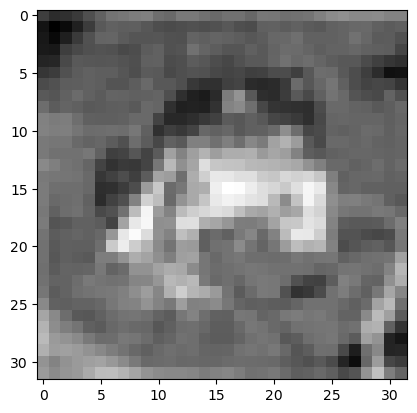

In [37]:
plt.imshow(img2, cmap="gray")

# Data Preparing

In [55]:
data = []
for i in range(2):
    fig = train_dataset[i][0]
    tensor_fig = (fig * 255).to(torch.uint8)
    fig_enc = encode(tensor_fig).to(torch.float)
    data.append(fig_enc)

loader = DataLoader(data, batch_size=batch_size, shuffle=False)

# Main

In [82]:
class HopfieldNet(nn.Module):
    def __init__(self):
        super(HopfieldNet, self).__init__()
        self.dropout = nn.Dropout(p=0.25)
        self.skip = nn.Linear(8192, 8192)
        self.down = nn.Linear(8192, 100)
        self.up   = nn.Linear(100, 8192)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.dropout(x)
        x_skip = self.skip(x)
        x_hidden = self.activation(self.down(x))
        x_hidden = self.activation(self.up(x_hidden))
        return x_skip + x_hidden

In [83]:
model = HopfieldNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [84]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for inputs in loader:
        optimizer.zero_grad()          # Clear gradients
        outputs = model(inputs)          # Forward pass
        loss = criterion(outputs, inputs)  # Compute reconstruction loss
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [1/10], Loss: 1.514116
Epoch [2/10], Loss: 0.586656
Epoch [3/10], Loss: 0.330015
Epoch [4/10], Loss: 0.395496
Epoch [5/10], Loss: 0.464758
Epoch [6/10], Loss: 0.444534
Epoch [7/10], Loss: 0.371025
Epoch [8/10], Loss: 0.299912
Epoch [9/10], Loss: 0.259813
Epoch [10/10], Loss: 0.246000


In [85]:
out1 = model(data[0])
binary_out = np.where(out1 < 0, -1, 1)

In [87]:
img_out = decode(binary_out)

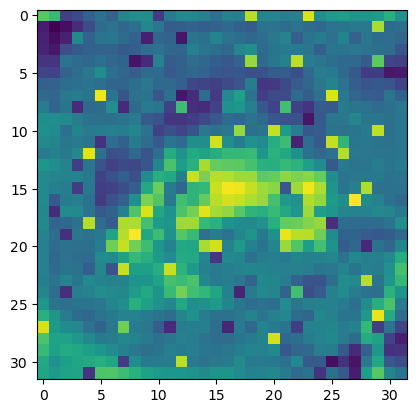

In [88]:
plt.imshow(img_out)